
# NBA Game Tweet Analysis (LAC v DAL Game 5)
This project involved using the Twitter API to get tweets live during Game 5 of the Clippers vs Mavericks NBA Playoff Series  and then doing some exploratory data analysis and sentiment analysis of the tweets.

The goals of this project were to better understand social media reactions to the game as well as overall sentiments towards each of the teams and players.






### Importing and description of data collected

In [1]:
import pandas as pd 

PATH_TO_CSV = '/content/drive/MyDrive/clippersVSmavs.csv'
# read tweets
tweets = pd.read_csv(PATH_TO_CSV, sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,4,5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
tweets.head()

,ID,Date,Text,Place,Location,Number_Follower,User_Name,Friends_count
0,1400271859371888643,2021-06-03-02:03:21,Idc what y’all say Luka being significantly be...,NaN,NaN,897,MFFLonly,1807
1,1400271862400270348,2021-06-03-02:03:22,Been saying this from the jump man bt y’all ai...,NaN,NaN,562,its_niaa__,457
2,1400271863096414208,2021-06-03-02:03:22,My brother @Ruke1981 who is the only real Clip...,"Florida, USA",NaN,218,Tozzcast,483
3,1400271863369117699,2021-06-03-02:03:22,@inden_l @vawterhokie99 @sschinke @AtomsksSana...,NaN,NaN,78,msabouri,428
4,1400271863557722116,2021-06-03-02:03:22,Fuck I’m a Mavericks fan the rest of the playoffs,NaN,NaN,1003,Westgoat_0,955


In [4]:
tweets.shape

(132428, 8)

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132428 entries, 0 to 132427
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ID               132428 non-null  object
 1   Date             132428 non-null  object
 2   Text             132428 non-null  object
 3   Place            2780 non-null    object
 4   Location         4 non-null       object
 5   Number_Follower  132428 non-null  object
 6   User_Name        132428 non-null  object
 7   Friends_count    132428 non-null  object
dtypes: object(8)
memory usage: 8.1+ MB


So, during the course of Game 5 including few minutes before tip off and post game, we have collected 132428 tweets. Note, only 2780 of the tweets have a place located with them and 4 have coordinates, meaning the scope of any analysis geographically is much more limited due to the data (this is due to users having to enable the location themselves, which many do not for privacy reasons).  Note, from our info method call we see that the number of non-null text in tweets is equal to the number of rows, so there is no null text, which is perfect for our analysis. 

### Exploratory Data Analysis

But before beginning, we will need to clean the text field given that it is quite difficult to do any processing or extract insights from. In addition, we will create some features after based on the data.


Our preprocessing pipeline is as follows:


1.   Remove punctuations and numbers
2.   Tokenize
3.   Remove stopwords
4.   Lemmatize words



In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string 
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:


def remove_punct(s):
  # Input: string s
  # Output: string s 
  # removes puncutation and numbers
  s  = "".join([char for char in s if char not in string.punctuation])
  s = re.sub('[0-9]+', '', s)
  return s 

def tokenization(s):
  # Input: string s
  # Output: List[string] s 
  # tokenizes string into tokens (lowercase)
  s = re.split('\W+', s)
  return [word.lower() for word in s]

# we use stopwords from nltk - common words that do not provide much value
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(s):
  # Input: List[string] s
  # Output: List[string] s 
  # removes stopwords in s
  return [token for token in s if token not in stopwords]

wn_lemmatizer = nltk.WordNetLemmatizer()


def lemmatize_words(s):
  # Input: List[string] s
  # Output: List[string] s 
  # lemmatize words - we chose lemmatizer since we can afford
  #              the lower speed to clean for better results
  return [wn_lemmatizer.lemmatize(word) for word in s]

  
def preprocess(s):
  # Input: string s
  # Output: List[string] s 
  # preprocesses the string
  s = remove_punct(s)
  s = tokenization(s)
  s = remove_stopwords(s)
  s = lemmatize_words(s)
  return s



In [8]:
# apply our cleaning!
tweets['Processed Text'] = tweets['Text'].apply(lambda x: preprocess(str(x)))
tweets['Processed Text string'] = tweets['Processed Text'].apply(lambda x: ' '.join(x))

In [9]:
tweets.head()

,ID,Date,Text,Place,Location,Number_Follower,User_Name,Friends_count,Processed Text,Processed Text string
0,1400271859371888643,2021-06-03-02:03:21,Idc what y’all say Luka being significantly be...,NaN,NaN,897,MFFLonly,1807,"[idc, say, luka, significantly, better, go, time]",idc say luka significantly better go time
1,1400271862400270348,2021-06-03-02:03:22,Been saying this from the jump man bt y’all ai...,NaN,NaN,562,its_niaa__,457,"[saying, jump, man, bt, wanna, faith, trae]",saying jump man bt wanna faith trae
2,1400271863096414208,2021-06-03-02:03:22,My brother @Ruke1981 who is the only real Clip...,"Florida, USA",NaN,218,Tozzcast,483,"[brother, ruke, real, clipper, fan, deserves, ...",brother ruke real clipper fan deserves apology...
3,1400271863369117699,2021-06-03-02:03:22,@inden_l @vawterhokie99 @sschinke @AtomsksSana...,NaN,NaN,78,msabouri,428,"[indenl, vawterhokie, sschinke, atomskssanakan...",indenl vawterhokie sschinke atomskssanakan yea...
4,1400271863557722116,2021-06-03-02:03:22,Fuck I’m a Mavericks fan the rest of the playoffs,NaN,NaN,1003,Westgoat_0,955,"[fuck, maverick, fan, rest, playoff]",fuck maverick fan rest playoff


#### N-Grams

In [10]:
def get_top_n_igrams(words, n, i):
  word_vectorizer = CountVectorizer(ngram_range=(i,i), analyzer='word').fit(words)
  sparse_matrix = word_vectorizer.transform(words)
  frequencies = sum(sparse_matrix).data
  df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=[ 'frequency'])
  df = df.sort_values('frequency', ascending=False).head(n)
  return df





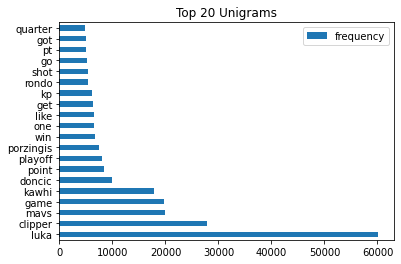

In [11]:
get_top_n_igrams(tweets['Processed Text string'], 20, 1).plot.barh(title = 'Top 20 Unigrams')

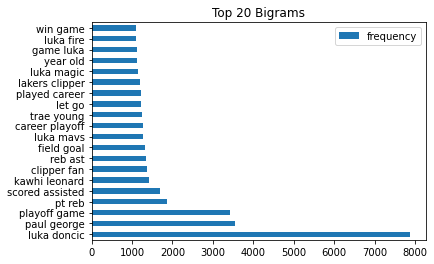

In [12]:
get_top_n_igrams(tweets['Processed Text string'], 20, 2).plot.barh(title = 'Top 20 Bigrams')

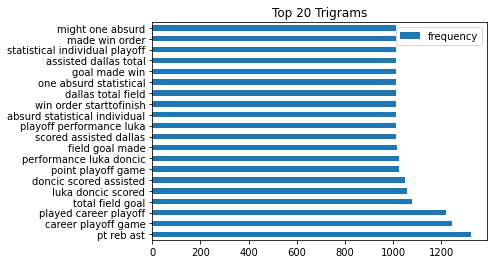

In [13]:
get_top_n_igrams(tweets['Processed Text string'], 20, 3).plot.barh(title = 'Top 20 Trigrams')

#### Sentiment Analysis
We will use the TextBlob library to do sentiment analysis on the tweets, which lets us classify the tweet sentiment with their pre-trained model without us having to label data. Obviously, this is a limitation as the structure of text in tweets may differ compared to the trained data used by the TextBlob API.

In [14]:
from textblob import TextBlob

In [15]:
tweets['Sentiment Polarity'] = tweets['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
tweets.head()

,ID,Date,Text,Place,Location,Number_Follower,User_Name,Friends_count,Processed Text,Processed Text string,Sentiment Polarity
0,1400271859371888643,2021-06-03-02:03:21,Idc what y’all say Luka being significantly be...,NaN,NaN,897,MFFLonly,1807,"[idc, say, luka, significantly, better, go, time]",idc say luka significantly better go time,0.500000
1,1400271862400270348,2021-06-03-02:03:22,Been saying this from the jump man bt y’all ai...,NaN,NaN,562,its_niaa__,457,"[saying, jump, man, bt, wanna, faith, trae]",saying jump man bt wanna faith trae,0.000000
2,1400271863096414208,2021-06-03-02:03:22,My brother @Ruke1981 who is the only real Clip...,"Florida, USA",NaN,218,Tozzcast,483,"[brother, ruke, real, clipper, fan, deserves, ...",brother ruke real clipper fan deserves apology...,0.014815
3,1400271863369117699,2021-06-03-02:03:22,@inden_l @vawterhokie99 @sschinke @AtomsksSana...,NaN,NaN,78,msabouri,428,"[indenl, vawterhokie, sschinke, atomskssanakan...",indenl vawterhokie sschinke atomskssanakan yea...,0.500000
4,1400271863557722116,2021-06-03-02:03:22,Fuck I’m a Mavericks fan the rest of the playoffs,NaN,NaN,1003,Westgoat_0,955,"[fuck, maverick, fan, rest, playoff]",fuck maverick fan rest playoff,-0.400000


In [16]:
# What are some positive examples of tweets?
positives = tweets.loc[tweets['Sentiment Polarity'] == 1, ['Text']].sample(5).values
positives

array([['lol Kawhi wasn’t gonna miss that !'],
       ['MAVS WIN!!!!! Aaaahhhhhhhhhhhh #MFFL #ALLIN https://t.co/Y7K5S9TWLl'],
       ['a perfect tweet'],
       ['Mavs win!'],
       ['Clippers might have the best whistle in the league 2 years in a row']],
      dtype=object)

In [17]:
# What are some negative examples of tweets?
negatives = tweets.loc[tweets['Sentiment Polarity'] == -1, ['Text']].sample(5).values
negatives

array([['Ofc Kawhi shoots an airball, smh. Horrible night'],
       ['fucking porzingis!!!'],
       ['Luka close outs are horrible!'],
       ['Boom! 3-2. Kawhi had an awful night shooting and Dallas took advantage of it'],
       ['KP legit the worst player in the playoffs']], dtype=object)

In [18]:
# What are some neutral examples of tweets?
neutral = tweets.loc[tweets['Sentiment Polarity'] == 0, ['Text']].sample(5).values
neutral

array([['Goddamn I could’ve sworn Clippers was just up 72-67 when I left'],
       ['Tf you doing?! - Rondo probably'],
       ['@SportsSturm Like compare Luka’s drive to PG’s'],
       ['Clippers hit a 3 to go to OT😱'],
       ['Someone gif that rondo air ball so I can tat it on the inside of my eyelids']],
      dtype=object)

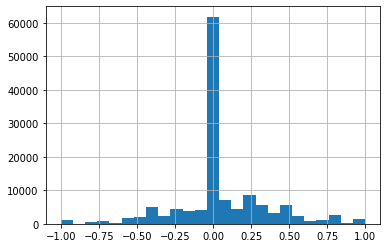

In [19]:
tweets['Sentiment Polarity'].hist(bins=25)

#### Tweet Activity


In [20]:
# First, we need DateTime types to be able to chart activity
tweets['DateTime'] = pd.to_datetime(tweets['Date'], errors='coerce', format="%Y-%m-%d-%H:%M:%S")


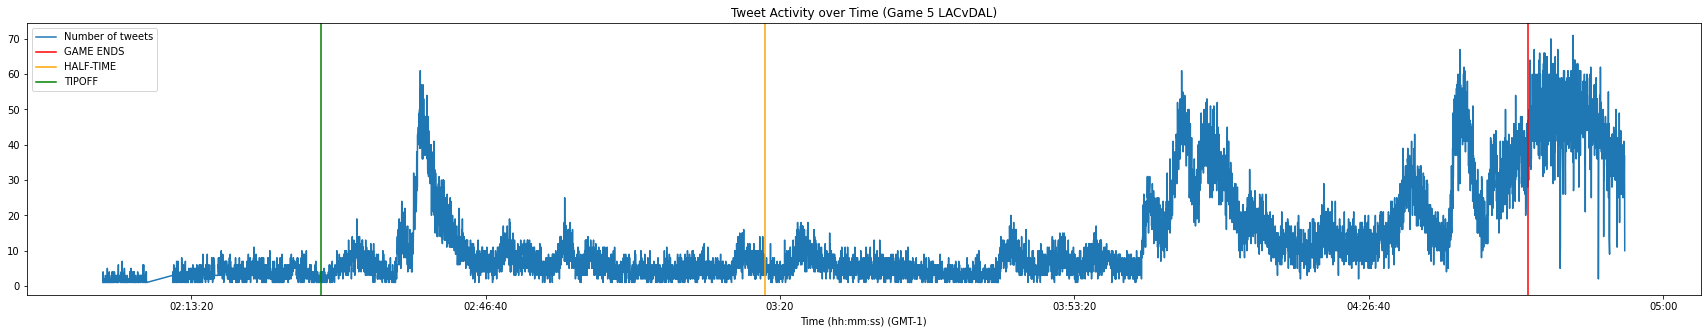

In [21]:
ax = tweets.groupby(tweets['DateTime'].rename('Time (hh:mm:ss) (GMT-1)').dt.time).size().plot(title='Tweet Activity over Time (Game 5 LACvDAL)', figsize=(30, 5), label = 'Number of tweets')
ax.axvline("4:44:40", color='red', label = 'GAME ENDS')
ax.axvline("3:18:22", color='orange', label = 'HALF-TIME')
ax.axvline("2:28:00", color='green', label = 'TIPOFF')
ax.legend()

Some context for the graph, the first huge spike after TIPOFF is around when the Mavericks got a 10 point lead late in the 1st quarter, in which the Clippers were not look great by then. The second huge sppike which is between half-time and end of game is when the Clippers went scoreless for a few minutes and the Mavericks had a 13-0 run to end the 3rd quarter. Then, we saw overall tweets per second be higher (relative to the first half) throughout to the end of the game. Interest continue to rose at the end of the game when the teams were neck in neck, and activity was at it's highest post game.

We can also see tweet activity mentioning specific players and how they align with the game.

In [23]:
luka_tweets = tweets.copy()
luka_tweets = luka_tweets[luka_tweets['Text'].str.contains('Luka', case=False)]



In [24]:
kawhi_tweets = tweets.copy()
kawhi_tweets = kawhi_tweets[kawhi_tweets['Text'].str.contains('Kawhi', case=False)]

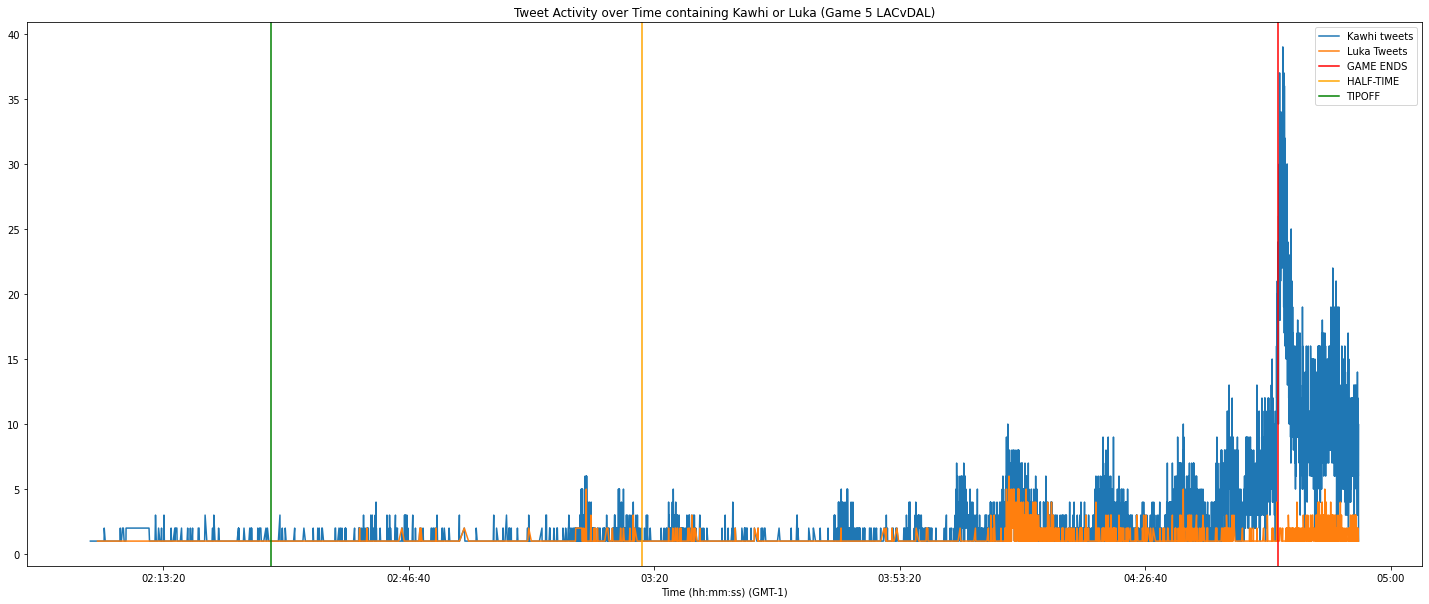

In [25]:
ax = kawhi_tweets.groupby(kawhi_tweets['DateTime'].rename('Time (hh:mm:ss) (GMT-1)').dt.time).size().plot(title='Tweet Activity over Time containing Kawhi or Luka (Game 5 LACvDAL)', figsize=(25, 10), label = 'Kawhi tweets')
ax = luka_tweets.groupby(kawhi_tweets['DateTime'].rename('Time (hh:mm:ss) (GMT-1)').dt.time).size().plot(figsize=(25, 10), label = 'Luka Tweets')


ax.axvline("4:44:40", color='red', label = 'GAME ENDS')
ax.axvline("3:18:22", color='orange', label = 'HALF-TIME')
ax.axvline("2:28:00", color='green', label = 'TIPOFF')
ax.legend()

We can also compare sentiment of tweets containing Kawhi and Luka over time to get a sense of overall reactions to the two superstars during the game.

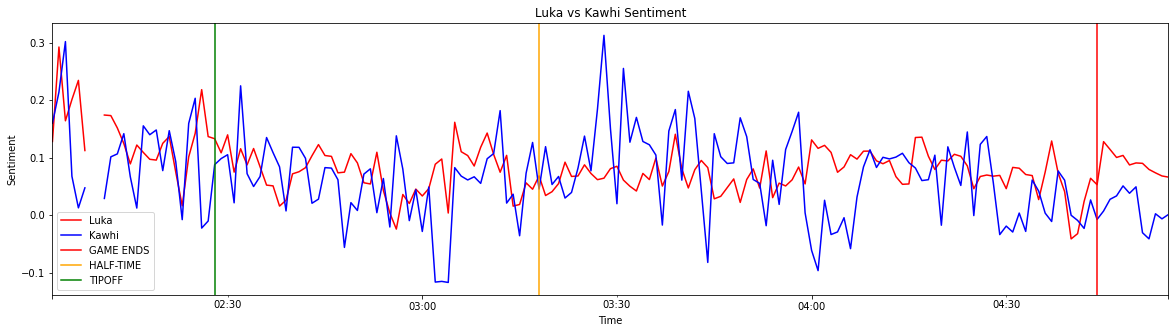

In [26]:

# change index to time
luka_tweets.set_index(pd.DatetimeIndex(luka_tweets['DateTime']), inplace=True)
kawhi_tweets.set_index(pd.DatetimeIndex(kawhi_tweets['DateTime']), inplace=True)

# get sentiment series
luka_sentiment = luka_tweets['Sentiment Polarity']
kawhi_sentiment = kawhi_tweets['Sentiment Polarity']

# resample by average over a minute as each second was not readable
luka_sentiment =  luka_sentiment.resample('1Min').mean()
kawhi_sentiment =  kawhi_sentiment.resample('1Min').mean()


#generate plot

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.set_title('Luka vs Kawhi Sentiment')


luka_sentiment.plot(ax=ax, color='red', label='Luka')
kawhi_sentiment.plot(ax=ax, color='Blue', label='Kawhi')
ax.set_xlabel('Time')
ax.set_ylabel('Sentiment')

ax.axvline("2021-06-03-4:44:40", color='red', label = 'GAME ENDS')
ax.axvline("2021-06-03-3:18:22", color='orange', label = 'HALF-TIME')
ax.axvline("2021-06-03-2:28:00", color='green', label = 'TIPOFF')
ax.legend()
plt.show()

#### Topic Modeling
Since we collected the data ourself and do not have labels, we will use the LDA Model to cluster the data so we can find general groupings of tweets. We will use gensim to help build a corpus.

In [27]:
tweet_tokens = tweets['Processed Text'].tolist()

In [28]:
import gensim.corpora as corpora
import gensim

# build dictionary
id2word = corpora.Dictionary(tweet_tokens)

# build corpus
corpus = tweet_tokens
corpus = [id2word.doc2bow(text) for text in corpus]

In [34]:
from pprint import pprint


NUM_TOPICS = 3


# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=NUM_TOPICS)



# Print the keywords in the  topics
pprint(lda_model.print_topics())

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

[(0,
  '0.049*"clipper" + 0.041*"game" + 0.031*"win" + 0.031*"mavs" + 0.024*"luka" '
  '+ 0.020*"kawhi" + 0.018*"" + 0.017*"lakers" + 0.015*"dallas" + 0.014*"pt"'),
 (1,
  '0.098*"luka" + 0.051*"doncic" + 0.030*"game" + 0.030*"playoff" + '
  '0.027*"one" + 0.019*"point" + 0.016*"absurd" + 0.016*"order" + '
  '0.015*"might" + 0.015*"individual"'),
 (2,
  '0.047*"kawhi" + 0.029*"rondo" + 0.025*"clipper" + 0.018*"" + 0.018*"shot" + '
  '0.015*"mavs" + 0.011*"like" + 0.010*"get" + 0.009*"ball" + 0.009*"luka"')]


In [35]:
# we can use pyLDAvis to visualize the topics
#  
# !pip install pyLDAvis==2.1.2
# if not installed in your environment; important to use
# version 2.1.2 as newer versions do not work well in Google Colab
import pickle 
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.202990  0.144299       1        1  41.489394
0      0.069708 -0.200467       2        1  32.633504
1     -0.272698  0.056168       3        1  25.877101, topic_info=         Term          Freq         Total Category  logprob  loglift
3        luka  37792.000000  37792.000000  Default  30.0000  30.0000
105    doncic  13582.000000  13582.000000  Default  29.0000  29.0000
16    clipper  27134.000000  27134.000000  Default  28.0000  28.0000
246       win  10785.000000  10785.000000  Default  27.0000  27.0000
395     rondo  12734.000000  12734.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2749   scored   2927.488968   5350.290240   Topic3  -4.5114   0.7488
165      year   1611.767128   2032.616420   Topic3  -5.1082   1.1198
24    tonight   2198.608863   4054.709579   Topic3  -4.7978   0.7398
73      kawhi   2189.173690  29104.434562   Topic3  -4.8021  -1.2356
58              1832.642332  15475.358199   Topic3  -4.9798  -0.7817

[246 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
58        1  0.487872        
58        2  0.393723        
58        3  0.118446        
5806      1  0.000235  absurd
5806      2  0.000705  absurd
...     ...       ...     ...
707       2  0.997570       x
165       1  0.024107    year
165       2  0.183015    year
165       3  0.793067    year
180       3  0.998935   young

[469 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

### Conclusions and Things to Improve

Overall, social media fans were more active towards the end of game and were tweeting more when the Mavericks had a greater lead, which seems to suggest Twitter was more active in support of the Mavericks. To confirm this, we could repeat the above analysis on the games and see trends in those that the Clippers have won.

In addition, we found that Twitter was more active regarding Luka Doncic than Kawhi Leonard and had a more positive sentiment towards Luka. 

With regards to topic modeling, we had clusters for each the Clippers and Mavericks , along with a cluster for general game.


With regards to improvements, some improvements would be to try more types of topic modelling and vectorization, includin TF-IDF vectorization and K-means clustering. 
